# First Look at Abalone Data
This notebook attempts to:
- Read in raw data
- Split-off a final test set of data
- Explore the training/validation data
- Use a basic model to perform predictions

In [1]:
%load_ext lab_black
%load_ext autoreload
%load_ext watermark

In [2]:
%autoreload 2

In [3]:
%watermark -ntz -p pandas -a Simon-Lee-UK -u -d -t -z

Author: Simon-Lee-UK

Last updated: 2021-05-06 08:59:51BST

pandas: 1.2.4



In [4]:
import sys
from pathlib import Path
import pandas as pd
from pandas_profiling import ProfileReport
from pyprojroot import here
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

sys.path.append(
    str(here())
)  # adds the project directory to a list of locations the python interpreter searches through when attempting to import modules

raw_data_path = here() / "data" / "raw" / "abalone_raw.csv"

In [5]:
def snake_case_column_headers(df):
    conversion_dict = {
        col_header: col_header.strip().lower().replace(" ", "_")
        for col_header in df.columns
    }
    return df.rename(conversion_dict, axis="columns")

## Read data, convert column headers and one-hot encode sex column
For now, dropped the one-hot encoded column for sex = infant.  
This information is already encoded via a zero in both the `sex_f` and `sex_m` columns.

In [6]:
abalone_all = (
    pd.read_csv(raw_data_path)
    .pipe(pd.get_dummies)
    .pipe(snake_case_column_headers)
    .drop("sex_i", axis="columns")
)

In [7]:
abalone_all.head(3)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_f,sex_m
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9,1,0


## Split data into training, validation (model comparison) and test sets

In [8]:
target_column = "rings"
X = abalone_all[[col for col in abalone_all.columns if col != target_column]]
y = abalone_all[[target_column]]

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101
)
training_full = pd.concat([X_train_full, y_train_full], axis="columns")

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=202
)

## Inspect the features of the training/validation set

In [10]:
report = ProfileReport(training_full, title="Pandas Profiling Overview")
# report

## Train an initial Random Forest model

In [11]:
rf_params = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [2, 4, 6, 8, 10, 12],
}

rf = RandomForestRegressor(random_state=42)
rf_gridsearch = GridSearchCV(rf, rf_params, n_jobs=-1, cv=5, verbose=5).fit(
    X_train, y_train.squeeze()
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [12]:
rf_gridsearch.best_estimator_

RandomForestRegressor(max_depth=8, n_estimators=300, random_state=42)

In [13]:
rf_gridsearch.best_score_

0.5679826995841937

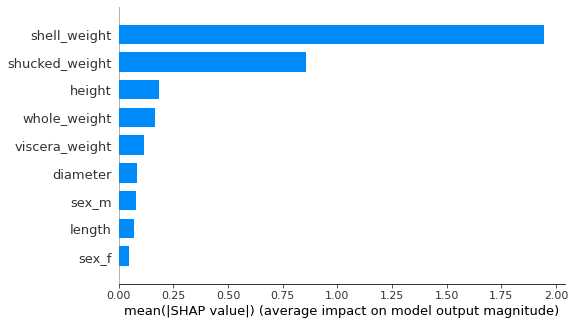

In [14]:
rf_shap_values = shap.TreeExplainer(rf_gridsearch.best_estimator_).shap_values(X_train)
shap.summary_plot(rf_shap_values, X_train, plot_type="bar")

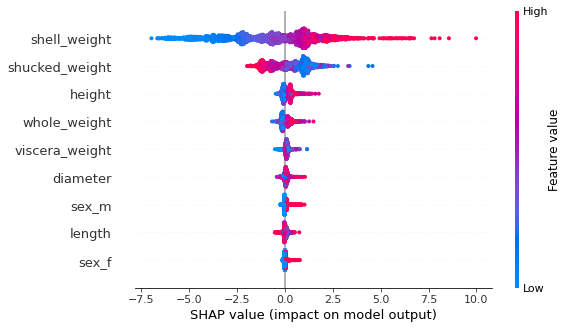

In [15]:
shap.summary_plot(rf_shap_values, X_train)

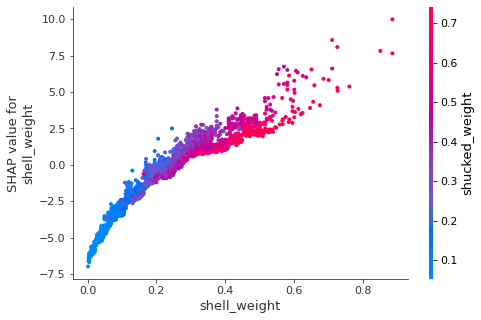

In [16]:
shap.dependence_plot("shell_weight", rf_shap_values, X_train)

Should give the [**SHAP package**](https://shap.readthedocs.io/en/latest/) a try for investigating the feature importance.  
Check first whether it works for regression as well as classification problems.  
  
Sounds like it does... [here](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30) is a good article on how it works.  
There are specialised functions for working with XGBoost; above I've started by looking at Random Forest results using the generalised TreeExplainer.